# <center>**Pneumonia X-Ray Images Classifier**</center></h1>
## <center>Machine Learning project - 2023/2024</center></h2>
### <center>Benedetta Pacilli <br/> benedetta.pacilli@studio.unibo.it <br/> ID: 0001136705  <br/> Valentina Pieri <br/> valentina.pieri5@studio.unibo.it <br/> ID: 0001137366 <br/> <br/> </center></h3>

# Introduction
In medical diagnostics, X-ray images are widely used to detect and diagnose diseases. In particular, chest X-ray images are used to detect pneumonia, a lung infection that can be caused by different agents. Pneumonia can be life-threatening, especially for people with a weak immune system, therefore it is important to detect pneumonia as soon as possible, in order to start the treatment and avoid complications.
This Machine Learning project aims to build a robust classifier that can distinguish between normal and pneumonia X-ray thoracic images. The project focuses on studying and employing various machine learning and deep learning algorithms to create multiple classifiers capable of accurately distinguishing between a normal and a pneumonia-affected patient.

The code is divided into 4 main parts:
- **Data import**: the dataset is imported
- **Data exploration**: the dataset is explored and analyzed
- **Machine Learning**: the dataset is used to train and test different machine learning models
- **Deep Learning**: the dataset is used to train and test different deep learning models


In [ ]:
# Code
The three following cells of code are needed only on Colab. The first one is the installation of kaggle and keras-tuner libraries, the second is necessary to work with kaggle APIs, and the third one makes the kaggle file fully readable and writable only to the owner of the file so that we don't get any warnings

In [1]:
# !pip install kaggle keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.4 MB/s eta 0:00:00


In [7]:
# import shutil
# shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

'/root/.kaggle/kaggle.json'

In [8]:
# !chmod 600 /root/.kaggle/kaggle.json

## Import libraries

Here we have imported all the libraries needed to run the code.

In [9]:
import pandas as pd
import os, shutil
import kaggle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from enum import Enum
from tqdm import tqdm
from skimage.feature import hog, local_binary_pattern
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Data Import

The dataset used is the [Chest X-ray images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) from Kaggle. It contains 5,863 X-ray images (JPEG) and 2 categories (Pneumonia/Normal). The images are divided into 3 folders: train, test and val. The train folder contains 5,216 images, the test folder contains 624 images and the val folder contains 16 images.
Each folder has two sub-folders: PNEUMONIA and NORMAL. The PNEUMONIA folder contains the images of the patients affected by pneumonia, while the NORMAL folder contains the images of the healthy patients.
We want to use the images as training data and the labels as target data.

In [10]:
if not os.path.exists('chest_xray'):
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', path='.', unzip=True)

We remove unecessary repetitive folders

In [11]:
def remove_dir(dir):
    if os.path.exists(dir):
        shutil.rmtree(dir)

In [12]:
remove_dir("chest_xray/chest_xray")
remove_dir("chest_xray/__MACOSX")

In order to manage and retrieve more easily the images we create two main folders: NORMAL and PNEUMONIA. Inside each of them we put all the images of the respective category, from the train, test and val folders.

In [13]:
def merge_folders(folder_paths, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    elif os.path.exists(destination_folder) and len(os.listdir(destination_folder)) > 0:
        print("Destination folder is not empty. Please choose another folder.")
        return

    for source_folder in folder_paths:
        for filename in os.listdir(source_folder):
            source_file_path = os.path.join(source_folder, filename)
            destination_file_path = os.path.join(destination_folder, filename)

            if os.path.exists(destination_file_path):
                base, ext = os.path.splitext(filename)
                new_filename = base + "_from_" + os.path.basename(source_folder) + ext
                destination_file_path = os.path.join(destination_folder, new_filename)

            shutil.copy2(source_file_path, destination_file_path)

In [14]:
folder_paths = ['chest_xray/test/NORMAL/', 'chest_xray/train/NORMAL/', 'chest_xray/val/NORMAL/']
destination_folder = 'chest_xray/NORMAL/'
merge_folders(folder_paths, destination_folder)
folder_paths = ['chest_xray/test/PNEUMONIA/', 'chest_xray/train/PNEUMONIA/', 'chest_xray/val/PNEUMONIA/']
destination_folder = 'chest_xray/PNEUMONIA/'
merge_folders(folder_paths, destination_folder)

We create four variables that contain the path of the main folder and the path of the subfolders since we will need them frequently.

In [15]:
path = 'chest_xray'
train = os.path.join(path, 'train')
test = os.path.join(path, 'test')
val = os.path.join(path, 'val')

## Dataframes Creation

We create three dataframes, one for each folder, that contain the path of each image and its label. After creation we show the content and structure of the dataframes.

In [16]:
def create_dataframe(path):
    df = pd.DataFrame(columns=['image', 'label'])
    for label in ['NORMAL', 'PNEUMONIA']:
        for image in os.listdir(os.path.join(path, label)):
            df = pd.concat([df, pd.DataFrame({'image': [image], 'label': [label]})], ignore_index=True)
    return df

In [17]:
train_df = create_dataframe(train)
val_df = create_dataframe(val)
test_df = create_dataframe(test)

In [ ]:
print("First 5 rows of train dataframe:")
print(train_df.head())
print()
print("Last 5 rows of train dataframe:")
print(train_df.tail())

First 5 rows of train dataframe:
                       image   label
0  NORMAL2-IM-0555-0001.jpeg  NORMAL
1          IM-0353-0001.jpeg  NORMAL
2  NORMAL2-IM-1100-0001.jpeg  NORMAL
3          IM-0276-0001.jpeg  NORMAL
4  NORMAL2-IM-0414-0001.jpeg  NORMAL

Last 5 rows of train dataframe:
                             image      label
5211  person337_bacteria_1564.jpeg  PNEUMONIA
5212    person1383_virus_2377.jpeg  PNEUMONIA
5213  person258_bacteria_1205.jpeg  PNEUMONIA
5214  person549_bacteria_2307.jpeg  PNEUMONIA
5215  person441_bacteria_1907.jpeg  PNEUMONIA


# Data Exploration

In this section we explore the dataset and analyze the images.
- **Data Redistribution**: we notices that the dataframes were unbalanced, so we decided to redistribute the data in order to have a balanced dataset.
- **Data Visualization**: we show some images of the dataset to provide a better understanding of the data we are working with.

## Data Redistribution

In [18]:
print("Dataframe total lenghts:")
print("Train: ", len(train_df))
print("Test: ", len(test_df))
print("Val: ", len(val_df))

Dataframe total lenghts:
Train:  5216
Test:  624
Val:  16


We redistribute the data using the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from the sklearn library. First we split the data into the train dataframe, containing the 70% of the whole data, and a second dataframe containing both test and val data. Then we split the second dataframe into the test dataframe, containing the 15% of the whole data, and the val dataframe, containing the 15% of the whole data. We show the new distribution of the data.

In [19]:
merged_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

train_df, test_val_df = train_test_split(merged_df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

print("Dataframe total lenghts after split:")
print("Train: ", len(train_df))
print("Test: ", len(test_df))
print("Val: ", len(val_df))

Dataframe total lenghts after split:
Train:  4099
Test:  878
Val:  879


## Data Visualization

Plotting the images we observed that the x-rays are not all the same size. Moreover some images are tilted to various degrees to the right or to the left.

We investigate further on the images with three subsections:
- **Classes distribution**: we show the distribution of the classes in the train, test and val dataframes.
- **Images size check**: we check the size of the images in the train, test and val dataframes.
- **Images brightness check**: we check the brightness of the images in the train, test and val dataframes.

In [ ]:
def plot_images(df, path, title):
    plt.figure(figsize=(20, 5))
    for i, image_index in enumerate(random.sample(range(df.shape[0]), 10)):


        ax = plt.subplot(2, 5, i + 1)
        image_path = os.path.join(path, df.iloc[image_index]['label'], df.iloc[image_index]['image'])

        try:
            image = cv2.imread(image_path)
            if image is not None:
                plt.imshow(image)
                plt.title(df.iloc[image_index]['label'])
                plt.axis("off")
            else:
                print(f"Error loading image: {image_path}")
        except Exception as e:
            print(f"Error loading image: {image_path}. Exception: {e}")

    plt.suptitle(title)
    plt.show()

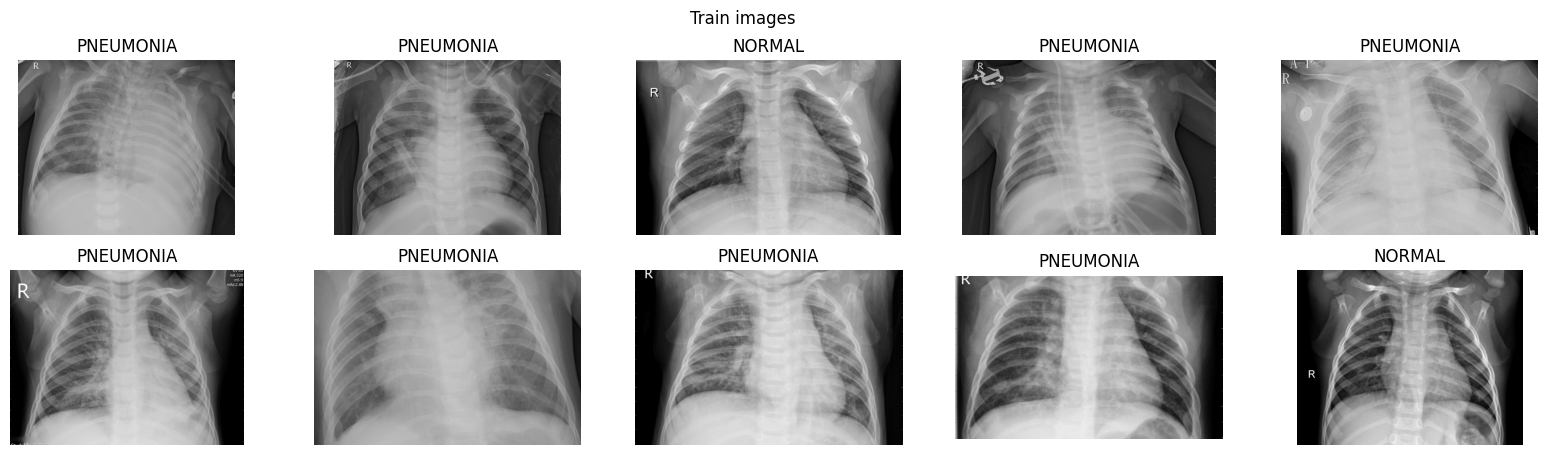

In [ ]:
plot_images(train_df, path, "Train images")

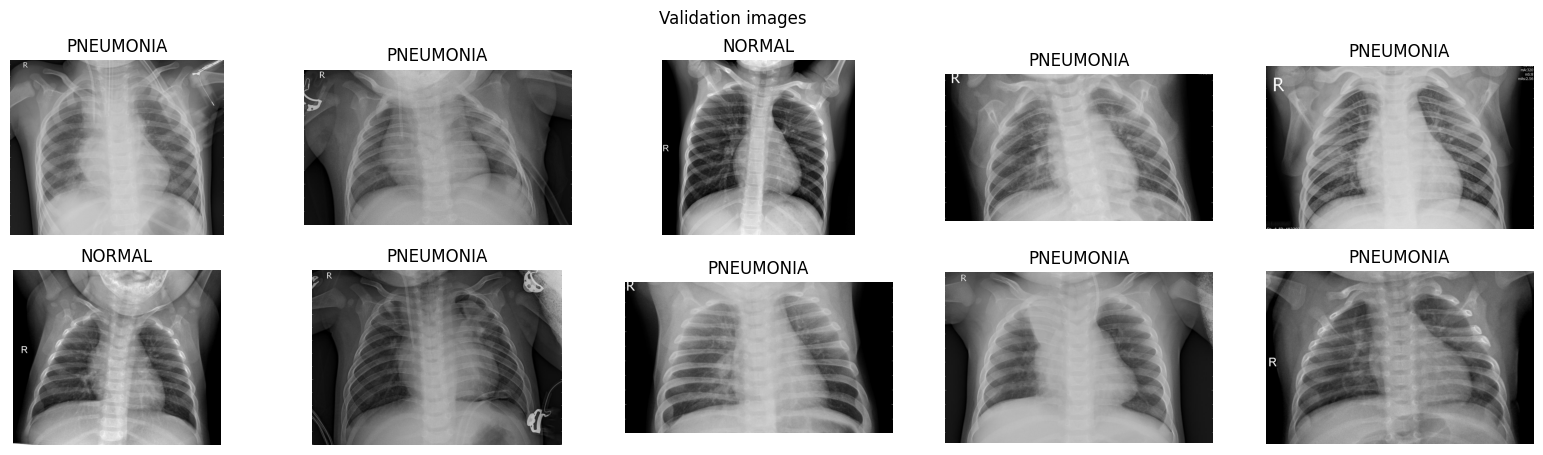

In [ ]:
plot_images(val_df, path, "Validation images")

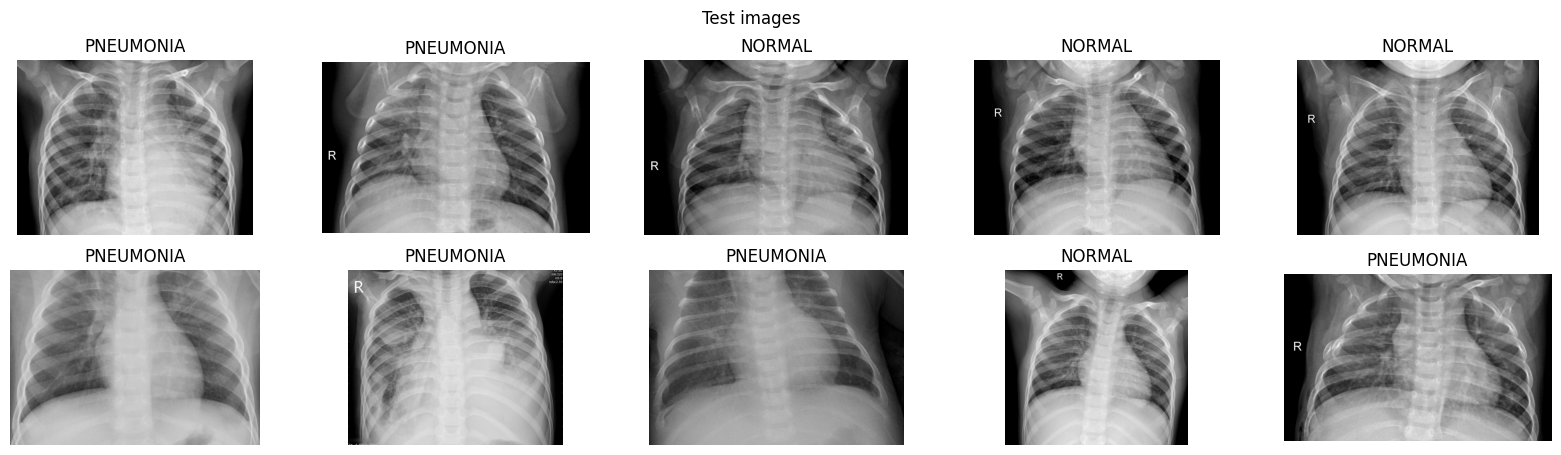

In [ ]:
plot_images(test_df, path, "Test images")

### Classes Distribution among Dataframes
In this subsection we show the distribution of the classes in the train, test and val dataframes. We notice that the dataframes are unbalanced. In each dataframe we have more images of healthy patients than images of patients affected by pneumonia. This could lead to a biased model but we didn't notice problems during the evaluation of the models.

In [ ]:
def create_pie_chart(df, title, colors=['#ff291e','#46a64e']):
    plt.pie(df['label'].value_counts(), labels=df['label'].unique(), autopct='%1.1f%%', colors=colors);
    plt.title(title);

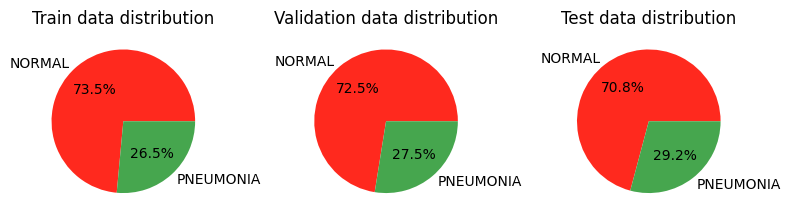

In [ ]:
plt.figure(figsize=(8,14))
plt.subplot(1, 3, 1)
create_pie_chart(train_df, 'Train data distribution')

plt.subplot(1, 3, 2)
create_pie_chart(val_df, 'Validation data distribution')

plt.subplot(1, 3, 3)
create_pie_chart(test_df, 'Test data distribution')

plt.tight_layout()
plt.show()

### Images Size Check

In this subsection we check the size of the images in the train, test and val dataframes. We notice that the images are not all the same size. This could lead to problems during the training of the models. In the preprocessing phase we will address this issue.

In [20]:
def get_images_dimension(df, path):
    heights = []
    widths = []
    for index, row in df.iterrows():
        image_name = row['image']
        label = row['label']
        img = cv2.imread(os.path.join(path, label, image_name))
        if img is not None:
            height, width = img.shape[:2]
            heights.append(height)
            widths.append(width)
        else:
            print(f"Image {image_name} is None")
    return heights, widths

In [21]:
train_heights, train_widths = get_images_dimension(train_df, path)
test_heights, test_widths = get_images_dimension(test_df, path)
val_heights, val_widths = get_images_dimension(val_df, path)

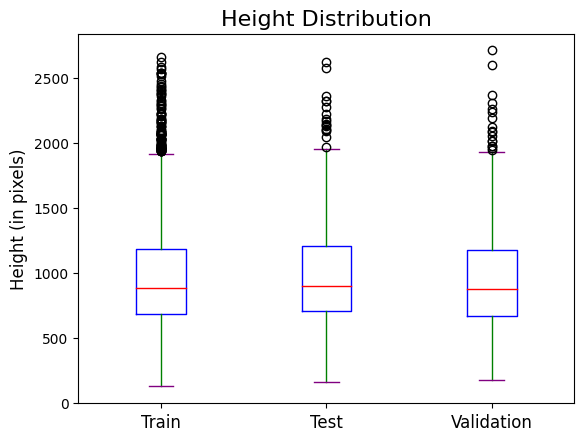

In [ ]:
plt.boxplot([train_heights, test_heights, val_heights], labels=['Train', 'Test', 'Validation'],
            boxprops=dict(color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='green'),
            capprops=dict(color='purple'));

plt.title('Height Distribution', fontsize=16);
plt.ylabel('Height (in pixels)', fontsize=12);
plt.xticks(fontsize=12);

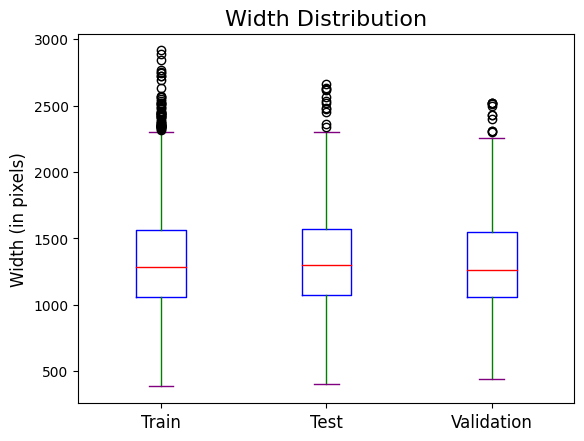

In [ ]:
plt.boxplot([train_widths, test_widths, val_widths], labels=['Train', 'Test', 'Validation'],
            boxprops=dict(color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='green'),
            capprops=dict(color='purple'));

plt.title('Width Distribution', fontsize=16);
plt.ylabel('Width (in pixels)', fontsize=12);
plt.xticks(fontsize=12);

From the box plots we noticed that the ranges of height and width are very wide. In the following code cells we plot images with particularly small dimesions. We can see that these images were cropped. This problem will be addressed in the preprocessing phase.

In [ ]:
def plot_random_small_images(df, path):
    count = 3
    images_per_row = 3
    fig, axes = plt.subplots(nrows=1, ncols=images_per_row, figsize=(15, 3))

    i = 0
    for index, row in df.iterrows():
        if i == count:
            break

        image_name = row['image']
        label = row['label']
        img = cv2.imread(os.path.join(path, label, image_name))
        height, width = img.shape[:2]

        if width < 250 or height < 200:
            axes[i % images_per_row].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i % images_per_row].set_title(f"Label: {row['label']}")
            axes[i % images_per_row].axis('off')

            i += 1

    plt.show()

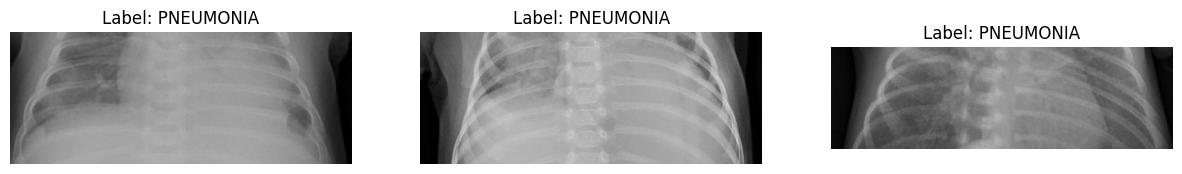

In [ ]:
plot_random_small_images(train_df, path)

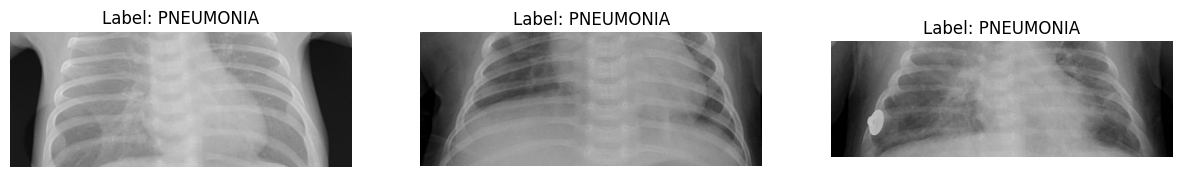

In [ ]:
plot_random_small_images(val_df, path)

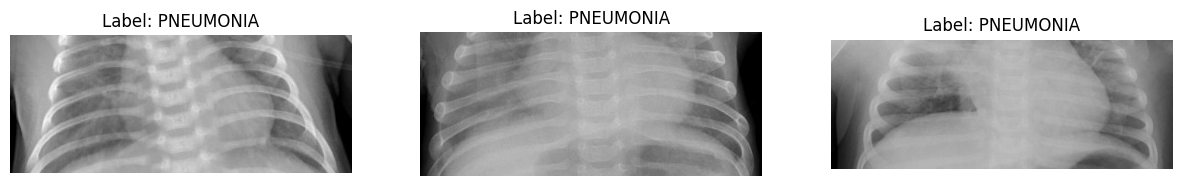

In [ ]:
plot_random_small_images(test_df, path)

### Images Brightness Check

Here we plot some images both with particularly low and high brightness. We address this issue in the preprocessing phase.

In [ ]:
def is_dark(image, threshold):
    return np.mean(image) < threshold

def is_light(image, threshold):
    return np.mean(image) > threshold

def plot_images_by_brightness(df, path, title, brightness_condition, brightess_threshold=100):
    plt.figure(figsize=(12, 4))
    count = 0
    i = 0
    while count < 10 and i < df.shape[0]:
        image_index = random.randint(0, df.shape[0] - 1)
        image_path = os.path.join(path, df.iloc[image_index]['label'], df.iloc[image_index]['image'])

        try:
            image = cv2.imread(image_path)
            if image is not None:
                if brightness_condition(image, brightess_threshold):
                    ax = plt.subplot(2, 5, count + 1)
                    plt.imshow(image)
                    plt.title(df.iloc[image_index]['label'])
                    plt.axis("off")
                    count += 1
        except Exception as e:
            print(f"Error loading image: {image_path}. Exception: {e}")

        i += 1

    plt.suptitle(title)
    plt.show()

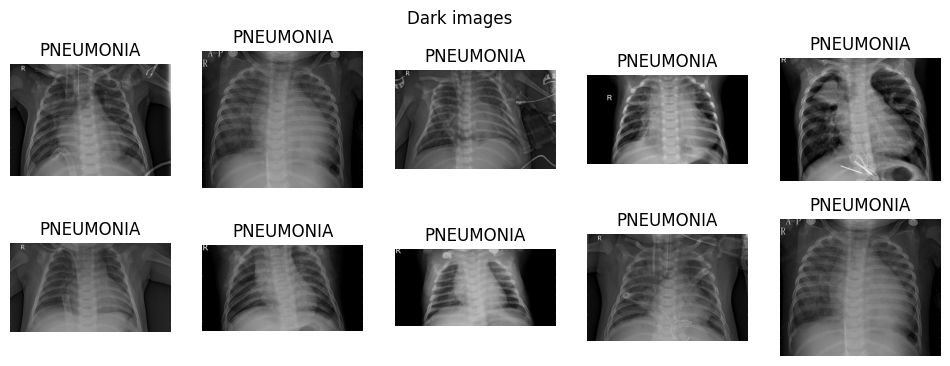

In [ ]:
plot_images_by_brightness(train_df, path, "Dark images", is_dark, 80)

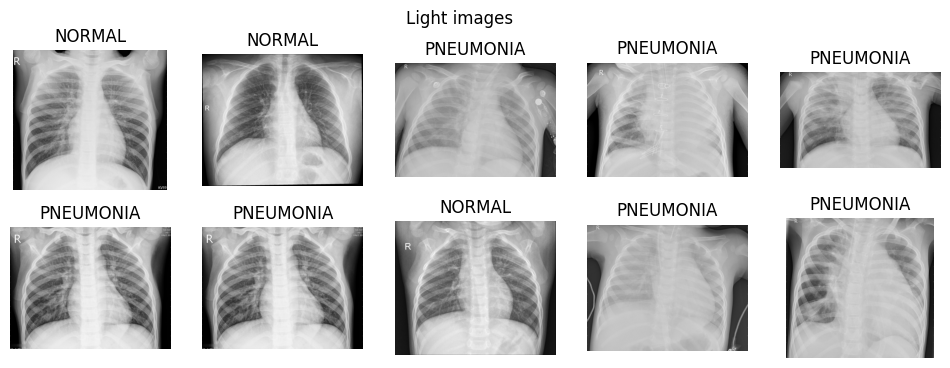

In [ ]:
plot_images_by_brightness(train_df, path, "Light images", is_light, 150)

# Machine Learning

In this section we train and test different machine learning models. We use the train dataframe to train the models and the test dataframe to test them. We use the val dataframe to validate the models.
The section is divided into 3 subsections:
- **Feature Extraction**: we extract features from the images.
- **Metrics Functions**: we define the metrics functions that we will use to evaluate the models.
- **Model Creation**: we create different machine learning models.
- **Evaluation of the best Models**: we evaluate the best models.

## Features Extraction

In this subsection we extract features from the images. We give the possibility to choose between three different methods:
- **HOG**: Histogram of Oriented Gradients. We use the [hog](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) function from the skimage library.
- **LBP**: Local Binary Patterns. We use the [local_binary_pattern](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) function from the skimage library.
- **IMG**: we divide each pixel by 255 to normalize the values and we flatten the image.

The function returns the features extracted and the labels.
For each dataframe we extract the features and the labels and we save them respectively in the x and y variables.

In [ ]:
def extract_features(df, feat_type, img_size):

    labels = []
    features = []

    for index, row in tqdm(df.iterrows()):
        image_name = row['image']
        label = row['label']

        image_path = os.path.join('chest_xray', label, image_name)

        img = cv2.imread(image_path, 0)

        img = cv2.resize(img, (img_size, img_size))

        if feat_type == 'hog':
            feat = hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1))
        elif feat_type == 'lbp':
            feat = np.ravel(local_binary_pattern(img, P=100, R=5))
        elif feat_type == 'img':
            img = img / 255.0
            feat = np.ravel(img)
        else:
            raise NotImplementedError('Not implemented feature!')

        if label == 'NORMAL':
          label = 0
        elif label == 'PNEUMONIA':
          label = 1

        features.append(feat)
        labels.append(label)

    return features, labels

In [ ]:
train_x, train_y = extract_features(train_df, 'hog', 224)
val_x, val_y = extract_features(val_df, 'hog', 224)
test_x, test_y = extract_features(test_df, 'hog', 224)

4099it [06:59,  9.77it/s]
879it [01:21, 10.72it/s]
878it [01:20, 10.85it/s]


## Metrics Functions

We create three functions that we will use to evaluate the models:
- **calculate_metrics_ml**: it calculates the precision, the recall and the f1-score of the model.
- **plot_confusion_matrix_ml**: it plots the confusion matrix of the model.
- **calculate_accuracy**: it calculates the accuracy for train, test and val data.

The metrics used are the following:
- **Precision**: it is the ratio of correctly predicted positive observations to the total predicted positive observations.
- **Recall**: it is the ratio of correctly predicted positive observations to the all observations in actual class.
- **F1-score**: it is the weighted average of Precision and Recall.
- **Accuracy**: it is the ratio of correctly predicted observations to the total observations.

In [ ]:
def calculate_metrics_ml(model, val_x, val_y):
  predictions = model.predict(val_x)
  precision = precision_score(val_y, predictions, average='binary')
  recall = recall_score(val_y, predictions, average='binary')
  f1 = f1_score(val_y, predictions, average='binary')

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

In [ ]:
def plot_confusion_matrix_ml(model, val_x, val_y):
    predictions = model.predict(val_x)
    cm = confusion_matrix(val_y, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def calculate_accuracy(model, train_x, train_y, test_x, test_y, val_x, val_y):
  predicted_train_y = model.predict(train_x)
  print(f"Train Accuracy: {accuracy_score(train_y, predicted_train_y):.2f}")

  predicted_test_y = model.predict(test_x)
  print(f"Test Accuracy: {accuracy_score(test_y, predicted_test_y):.2f}")

  print(f"Val Accuracy: {model.score(val_x, val_y):.2f}")

## Model Creation

In this subsection we create different machine learning models. We decided to test the following algorithms:
- **SVM**: Support Vector Machine. We use the [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) function from the sklearn library.
- **Random Forest**: We use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) function from the sklearn library.
- **Decision Tree**: We use the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) function from the sklearn library.
- **AdaBoost**: We use the [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) function from the sklearn library.
- **xgboost**: We use the [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier) function from the xgboost library.

### SVM

For the Support Vector Machine model we choose the following parameters:
- **gamma**: it is the kernel coefficient for the rbf, poly and sigmoid kernels. We choose the value `0.0001`.
- **C**: it is the regularization parameter. We choose the value `100`.
- **kernel**: it is the kernel type to be used in the algorithm. We choose the `rbf` kernel meaning that we use a non-linear kernel.

In [ ]:
ml_model_svm = svm.SVC(gamma=0.0001, C=100, kernel='rbf', verbose=False)
ml_model_svm.fit(train_x, train_y)
calculate_accuracy(ml_model_svm, train_x, train_y, test_x, test_y, val_x, val_y)

Train Accuracy: 1.00
Test Accuracy: 0.96
Val Accuracy: 0.96


The train accuracy is very high, while the test and val accuracies are sligltly lower. This could mean that the model is overfitting. We tried to change the parameters but we noticed that whenever the train accuracy decreased the test and val accuracies decreased significantly as well. So we decided to keep the configuration shown above.

In [ ]:
calculate_metrics_ml(ml_model_svm, val_x, val_y)

Precision: 0.9673405909797823
Recall: 0.9764521193092621
F1 Score: 0.971875


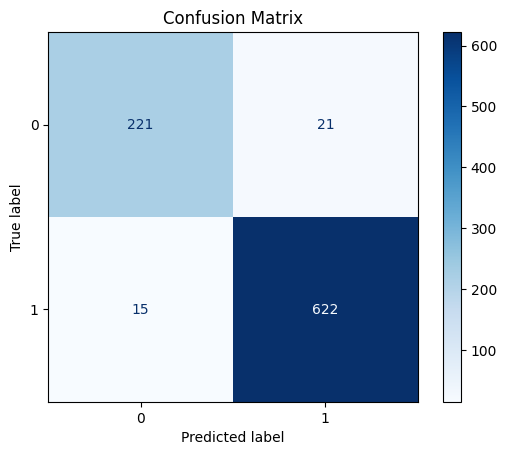

In [ ]:
plot_confusion_matrix_ml(ml_model_svm, val_x, val_y)

As we can see from the confusion matrix the model is able to correctly classify the images of the val dataframe: it correctly classified `622` pneumonia images out of `637` and `221` healthy images out of `242`.

### Random Forest

For the Random Forest model we choose the following parameters:
- **n_jobs**: it is the number of jobs to run in parallel. We choose the value `-1` meaning that we use all processors.
- **bootstrap**: it is whether bootstrap samples are used when building trees. We choose the value `True`.
- **criterion**: it is the function to measure the quality of a split. We choose the `entropy` criterion.
- **max_features**: it is the number of features to consider when looking for the best split. We choose the value `sqrt` meaning that we use the square root of the number of features.
- **n_estimators**: it is the number of trees in the forest. We choose the value `200`.
- **max_depth**: it is the maximum depth of the tree. We choose the value `100`.

In [ ]:
ml_model_random_forest = RandomForestClassifier(n_jobs=-1, bootstrap=True, criterion='entropy', max_features='sqrt', n_estimators=200, max_depth=100, random_state=42)
ml_model_random_forest.fit(train_x, train_y)
calculate_accuracy(ml_model_random_forest, train_x, train_y, test_x, test_y, val_x, val_y)

Train Accuracy: 1.00
Test Accuracy: 0.88
Val Accuracy: 0.89


The train accuracy is very high, while the test and val accuracies are sligltly lower. This could mean that the model is overfitting. We tried to change the parameters but we noticed that whenever the train accuracy decreased the test and val accuracies decreased significantly as well. So we decided to keep the configuration shown above.

In [ ]:
calculate_metrics_ml(ml_model_random_forest, val_x, val_y)

Precision: 0.8918128654970761
Recall: 0.957613814756672
F1 Score: 0.9235427706283119


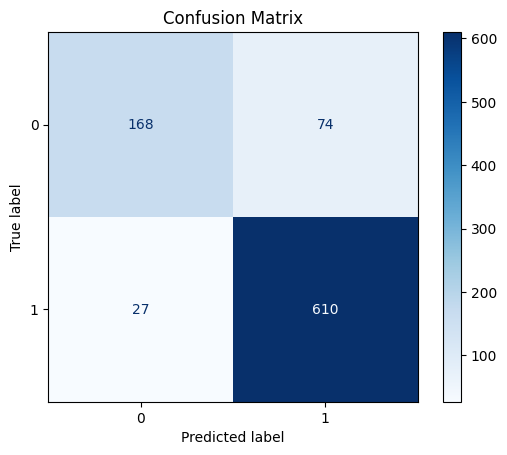

In [ ]:
plot_confusion_matrix_ml(ml_model_random_forest, val_x, val_y)

From the metrics and the confusion matrix we can see that the model performs well, but not as well as the SVM model.

### Decision Tree

For the Decision Tree model we choose the following parameters:
- **criterion**: it is the function to measure the quality of a split. We choose the `entropy` criterion.
- **max_depth**: it is the maximum depth of the tree. We choose the value `100`.

In [ ]:
ml_model_decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=100, random_state=42)
ml_model_decision_tree.fit(train_x, train_y)
calculate_accuracy(ml_model_decision_tree, train_x, train_y, test_x, test_y, val_x, val_y)

Train Accuracy: 1.00
Test Accuracy: 0.81
Val Accuracy: 0.82


In [ ]:
calculate_metrics_ml(ml_model_decision_tree, val_x, val_y)

Precision: 0.8814102564102564
Recall: 0.8634222919937206
F1 Score: 0.8723235527359238


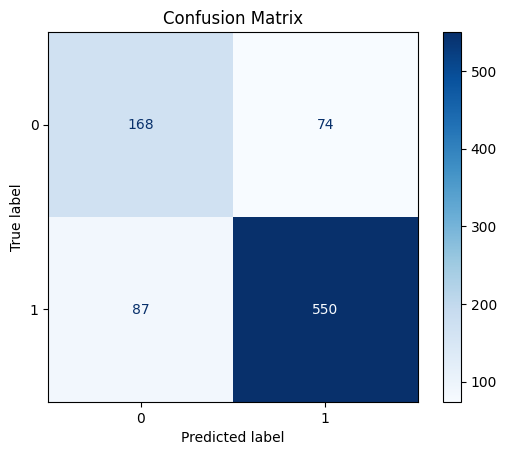

In [ ]:
plot_confusion_matrix_ml(ml_model_decision_tree, val_x, val_y)

We can see that the Decision Tree algorithm is outperformed both by the SVM and the Random Forest algorithms.

### AdaBoost

For the AdaBoost model we choose the following parameters:
- **estimator**: it is the base estimator from which the boosted ensemble is built. We choose the `DecisionTreeClassifier` function from the sklearn library. We specify **max_depth**=`1` as we experimented with different combinations and found out that this configuration gives very good results while keeping the training time low.
- **n_estimators**: it is the maximum number of estimators at which boosting is terminated. We choose the value `50`.

In [ ]:
ml_model_adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)
ml_model_adaboost.fit(train_x, train_y)
calculate_accuracy(ml_model_adaboost, train_x, train_y, test_x, test_y, val_x, val_y)

Train Accuracy: 0.95
Test Accuracy: 0.90
Val Accuracy: 0.90


In this case the train accuracy is lower than the one from SVM and Random Forest models. Here we can state that the model is not overfitting.

In [ ]:
calculate_metrics_ml(ml_model_adaboost, val_x, val_y)

Precision: 0.9308176100628931
Recall: 0.9293563579277865
F1 Score: 0.9300864100549882


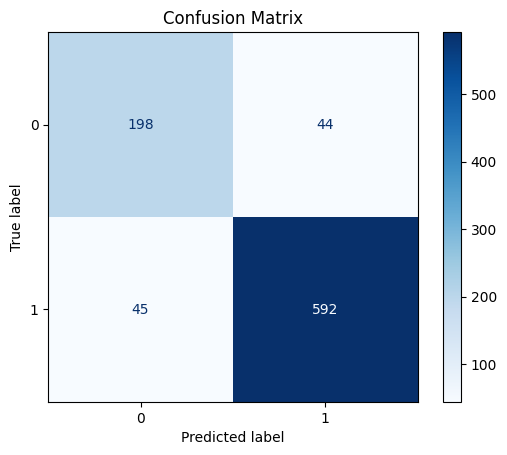

In [ ]:
plot_confusion_matrix_ml(ml_model_adaboost, val_x, val_y)

Even though this confusion matrix is not as accurate as the SVM one, we observe that the AdaBoost model performs better than the Random Forest model when it comes to predicting the healthy images. On the other hand, the Random Forest model performs better than the AdaBoost model when it comes to predicting the pneumonia images.

### xgBoost

For the xgBoost model we choose the following parameters:
- **objective**: it is the learning objective. We choose the `multi:softmax` objective.
- **num_class**: it is the number of classes. We choose the value `2` because we only have two classes.
- **max_depth**: it is the maximum depth of a tree. We choose the value `3`.
- **learning_rate**: it is the step size shrinkage used to prevent overfitting. We choose the value `0.00001`.
- **n_estimators**: it is the number of trees to fit. We choose the value `100`.
- **subsample**: it is the subsample ratio of the training instances. We choose the value `0.8`.
- **colsample_bytree**: it is the subsample ratio of columns when constructing each tree. We choose the value `0.8`.

In [ ]:
ml_model_xgboost = xgb.XGBClassifier(objective='multi:softmax', num_class=2, max_depth=3, learning_rate=0.00001, n_estimators=100, subsample=0.8, colsample_bytree=0.8, random_state=42)
ml_model_xgboost.fit(train_x, train_y)
calculate_accuracy(ml_model_xgboost, train_x, train_y, test_x, test_y, val_x, val_y)

Train Accuracy: 0.84
Test Accuracy: 0.84
Val Accuracy: 0.84


Despite lower accuracies, we decided to keep this model on the notebook as we wanted to explore an algorith not studied during the labs.

In [ ]:
calculate_metrics_ml(ml_model_xgboost, val_x, val_y)

Precision: 0.8983870967741936
Recall: 0.8744113029827315
F1 Score: 0.8862370723945902


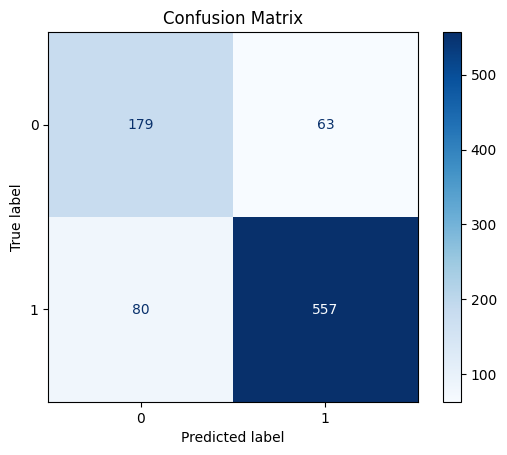

In [ ]:
plot_confusion_matrix_ml(ml_model_xgboost, val_x, val_y)

## Inference of Best Models

In this subsection we run inference the best models: SVM, Random Forest and AdaBoost. In order to do so we make our models predict the labels of the test data, which they have never seen before. We take 10 random test images and we print their true labels and predicted labels. We can see that the models are able to correctly classify the images, accordingly to the metrics and confusion matrix shown above.

In [ ]:
def perform_inference(model, test_x, test_y):
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    random_indexes = np.random.choice(len(test_x), size=10, replace=False)
    for index in random_indexes:
      true_label = 'NORMAL' if test_y[index] == 0 else 'PNEUMONIA'
      predicted_label = 'NORMAL' if model.predict(test_x[index].reshape((1, -1)))[0] == 0 else 'PNEUMONIA'
      print(f'True label: {true_label}')
      print(f'Predicted label: {predicted_label}')
      print('---------------------------------------')

#### SVM Inference

In [ ]:
perform_inference(ml_model_svm, test_x, test_y)

True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: NORMAL
Predicted label: NORMAL
---------------------------------------
True label: NORMAL
Predicted label: NORMAL
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------


AdaBoost Inference

In [ ]:
perform_inference(ml_model_adaboost, test_x, test_y)

True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: NORMAL
Predicted label: NORMAL
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: NORMAL
Predicted label: NORMAL
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: NORMAL
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: NORMAL
Predicted label: NORMAL
---------------------------------------


#### RandomForest Inference

In [ ]:
perform_inference(ml_model_random_forest, test_x, test_y)

True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: NORMAL
Predicted label: NORMAL
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: NORMAL
Predicted label: NORMAL
---------------------------------------
True label: NORMAL
Predicted label: NORMAL
---------------------------------------
True label: NORMAL
Predicted label: NORMAL
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------
True label: PNEUMONIA
Predicted label: PNEUMONIA
---------------------------------------


# Deep Learning

In this section we train and test different deep learning models. The following are the subsections:
- **Data Preprocessing**: we preprocess the data in order to make it suitable for the deep learning models considering the observations made in the data exploration phase.
- **Model Creation**: we create and evaluate a deep learning model with different data.
- **Model Inference**: we run inference on the best model.

## Data Preprocessing

Before the preprocessing phase we create datasets from the dataframes to make them suitable for the deep learning models.

### Dataset Creation

We create three datasets, one for each dataframe, that contain the images and the labels. The datasets are created using the [from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) function from the tensorflow library. Then we show the content and structure of the train dataset.

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image'].values, train_df['label'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['image'].values, test_df['label'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['image'].values, val_df['label'].values))

In [ ]:
print("Train dataset:")
for image, label in train_dataset.take(5):
    print(f"Image: {image.numpy()}, Label: {label.numpy()}")

Train dataset:
Image: b'NORMAL2-IM-0879-0001.jpeg', Label: b'NORMAL'
Image: b'person1612_virus_2797.jpeg', Label: b'PNEUMONIA'
Image: b'IM-0437-0001-0002.jpeg', Label: b'NORMAL'
Image: b'person130_bacteria_623.jpeg', Label: b'PNEUMONIA'
Image: b'person579_bacteria_2384.jpeg', Label: b'PNEUMONIA'


The following two functions are fundamental for the preprocessing phase:
- **preprocess_image_and_label**: it preprocesses the images and the labels. It resizes the images to the size `224x224`, it normalizes the values of the images and it one-hot encodes the labels.
- **prepare_data**: it prepares the data for the deep learning models. It applies the `preprocess_image_and_label` function to the images and the labels and then it shuffles the data. Then according to the parameters passed to the function it perfomes color jittering or layer augmentation.
    - **color jittering**: it performs color jittering on the images. It randomly changes the brightness, the contrast, the saturation and the hue of the images. We did this to make the model more robust to different lighting conditions as we previously noticed that some images were very dark and some were very bright.
    - **layer augmentation**: it performs layer augmentation on the images. It randomly applies horizontal and vertical flips, random rotations and random zooms to the images. This helps the model to generalize better since the original images were either not all the same size, tilted or cropped.

In [23]:
def preprocess_image_and_label(img_name, label):
    file_path_str = tf.strings.join(["chest_xray", label, img_name], separator=os.path.sep)
    img = tf.io.read_file(file_path_str)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_pad(img, 224, 224)
    img /= 255.0
    label = tf.where(tf.equal(label, 'NORMAL'), 0, 1)
    return img, label

In [24]:
def prepare_data(ds, batch_size, shuffle=True, shuffle_buffer_size=1000, jitter=False, layers_augmentation=False):
    ds = ds.map(preprocess_image_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    if jitter:
        ds = ds.map(lambda x, y: (tf.image.random_brightness(x, max_delta=0.1, seed=42), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_contrast(x, lower=0.1, upper=0.2, seed=42), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_saturation(x, lower=0.1, upper=0.2, seed=42), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_hue(x, max_delta=0.1, seed=42), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if layers_augmentation:
        ds = ds.map(lambda x, y: (tf.image.random_flip_left_right(x, seed=42), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_flip_up_down(x, seed=42), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.rot90(x, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.central_crop(x, central_fraction=tf.random.uniform(shape=[], minval=0.8, maxval=1.0, dtype=tf.float32)), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.resize_with_pad(x, 224, 224), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

In [25]:
batch_size = 16
train_ds = prepare_data(train_dataset, batch_size, shuffle=True, shuffle_buffer_size=1000, jitter=True, layers_augmentation=True)
test_ds = prepare_data(test_dataset, batch_size, shuffle=False)
val_ds = prepare_data(val_dataset, batch_size, shuffle=False)

Here we show single batches of each dataset. In the first two cells we show the labels of the train dataset, since we have applied shuffling we can see that we get different data every time we run the code.

In [ ]:
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch Size: {images.shape[0]}")
    print(f"Labels: {labels}")

Batch of images shape: (16, 224, 224, 3)
Batch Size: 16
Labels: [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]


In [ ]:
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch Size: {images.shape[0]}")
    print(f"Labels: {labels}")

Batch of images shape: (16, 224, 224, 3)
Batch Size: 16
Labels: [1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0]


In [ ]:
for images, labels in test_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch Size: {images.shape[0]}")
    print(f"Labels: {labels}")

Batch of images shape: (16, 224, 224, 3)
Batch Size: 16
Labels: [0 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0]


In [ ]:
for images, labels in val_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch Size: {images.shape[0]}")
    print(f"Labels: {labels}")

Batch of images shape: (16, 224, 224, 3)
Batch Size: 16
Labels: [0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1]


In this code cell we print the first tensor of the train dataset. We can see that the tensor has 4 dimensions: the first dimension is the batch size, the second and third dimensions are the height and width of the image, the fourth dimension is the number of channels of the image. In this case we have 3 channels because the images are RGB. <br/>
`images[0,:,:,0]`: the first `0` means that we are considering the first tensor of the dataset, the second and third `:` mean that we are considering all the rows and columns of the tensor, the last element `0` means that we are considering the first channel of the tensor.

In [ ]:
for images, labels in train_ds.take(1):
    print(images[0,:,:,0])

tf.Tensor(
[[0.38326848 0.38326848 0.38326848 ... 0.38326848 0.38326848 0.38326848]
 [0.38326848 0.38326848 0.38326848 ... 0.38326848 0.38326848 0.38326848]
 [0.38326848 0.38326848 0.38326848 ... 0.38326848 0.38326848 0.38326848]
 ...
 [0.38326848 0.38326848 0.38326848 ... 0.38326848 0.38326848 0.38326848]
 [0.38326848 0.38326848 0.38326848 ... 0.38326848 0.38326848 0.38326848]
 [0.38326848 0.38326848 0.38326848 ... 0.38326848 0.38326848 0.38326848]], shape=(224, 224), dtype=float32)


## Model Creation

In this subsection we create a deep learning model architecture and we train it with differently preprocessed data.
This part is divided into 3 subsections:
- **Metrics Functions**: we define the metrics functions that we will use to evaluate the models.
- **Model Architecture Building**: we build the model architecture.
- **Using Color Jittering**: we train the model with data preprocessed with color jittering.
- **Using Layer Augmentation**: we train the model with data preprocessed with layer augmentation.

### Metrics functions

We create four functions that we will use to evaluate the models:
- **plot_training_loss_accuracy_history**: it plots the training loss and accuracy history of the model through the epochs.
- **evaluate_model**: it evaluates the model on the test data, calculating its loss and accuracy.
- **calculate_metrics**: it calculates the precision, the recall and the f1-score of the model.
- **plot_confusion_matrix**: it plots the confusion matrix of the model.

In [26]:
def plot_training_loss_accuracy_history(history_name, start_epoch=1):
    train_loss = history_name.history['loss']
    val_loss = history_name.history['val_loss']
    train_acc = history_name.history['accuracy']
    val_acc = history_name.history['val_accuracy']
    learning_rate = history_name.history['lr']

    range_epoch= np.arange(start_epoch, start_epoch + len(train_loss))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range_epoch, train_loss, label='Training Loss',marker='o', color='red')
    plt.plot(range_epoch, val_loss, label='Validation Loss',marker='x',color='blue')
    plt.plot(range_epoch, learning_rate, label='learning_rate',marker='*',color='green')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss)))

    plt.subplot(1, 2, 2)
    plt.plot(range_epoch, train_acc, label='Training Accuracy',marker='o',color='red')
    plt.plot(range_epoch, val_acc, label='Validation Accuracy',marker='x',color='blue')
    plt.plot(range_epoch, learning_rate, label='learning_rate',marker='*',color='green')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range_epoch)
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss)))

    plt.show()

In [27]:
def evaluate_model(model, test_ds):
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")

In [28]:
def calculate_metrics(model, ds):
    y_true = []
    y_pred = []

    for images, labels in ds:
        y_true.extend(labels.numpy())
        y_pred.extend(tf.squeeze(tf.round(model.predict(images, verbose=0))).numpy())

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1score}")

In [29]:
def plot_confusion_matrix(model, ds):
    y_true = []
    y_pred = []

    for images, labels in ds:
        y_true.extend(labels.numpy())
        y_pred.extend(tf.squeeze(tf.round(model.predict(images, verbose=0))).numpy())

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    cm = ConfusionMatrixDisplay(cm, display_labels=['NORMAL', 'PNEUMONIA'])
    cm.plot(cmap='Blues')

### Model Architecture Building

In this subsection is present the **build_model** function that builds the CNN model architecture. It employs the tf.keras.Sequential function to create a sequential model. The model is composed by:
- **Conv2D**: it is a 2D convolutional layer that it is used over images because of their 2D nature. It applies a convolutional operation to the input. We use the `relu` activation function to introduce non-linearity in the model so that it can learn complex relationship within the data.
- **MaxPooling2D**: it is a 2D pooling layer that it is used over images because of their 2D nature. It downsamples the input along its spatial dimensions. We choose the `2x2` size so that the layer will halve the input in both spatial dimensions.
- **Conv2D + MaxPooling2D**: we use another 2D convolutional layer together with another 2D pooling layer. This way we can extract more features from the images and the model builds the new features learned, from the previous combination of Conv2D and MaxPooling2D layers. In fact we experimented both with a single a combiantion of Conv2D and MaxPooling2D layers and with two combinations of Conv2D and MaxPooling2D layers and we found out that the latter gives way better results.
- **Dropout**: it is a regularization technique that randomly drops neurons from the neural network during training. We choose the value `0.2` meaning that we drop `20%` of the neurons, causing the specified amount of input percentage to be set to `0`. Doing so we prevent the model from overfitting.
- **Flatten**: it flattens the input. It transforms the input into a 1D array. We need to do this because the input of the next layer must be a 1D array.
- **Dense**: it is a densely-connected layer. It is a fully connected layer, meaning that each neuron in the layer is connected to every neuron in the previous layer. We choose the `relu` activation function to introduce non-linearity in the model so that it can learn complex relationship within the data. We place four dense layers, each with a different amount of neurons. In the last dense layer we use the `sigmoid` activation function because we want to classify the images into two classes: pneumonia or normal.

The number of neurons in the first three dense layers and the learning rate are passed as parameters to the function. We found the best values for these hyperparameters by experimenting through grid search.

In [30]:
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(input_shape=(224,224,3)),
        tf.keras.layers.Dense(hp.Int('dense_1_units', min_value=64, max_value=256, step=32), activation='relu'),
        tf.keras.layers.Dense(hp.Int('dense_2_units', min_value=32, max_value=128, step=16), activation='relu'),
        tf.keras.layers.Dense(hp.Int('dense_3_units', min_value=16, max_value=64, step=8), activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### Using Color Jittering

Here we train our model architecture with data preprocessed with color jittering. We prepared the three datasets using the **prepare_data** function previously described.

In [31]:
train_ds_jitter = prepare_data(train_dataset, batch_size, shuffle=True, shuffle_buffer_size=1000, jitter=True, layers_augmentation=False)
val_ds_jitter = prepare_data(val_dataset, batch_size, shuffle=False, jitter=True, layers_augmentation=False)
test_ds_jitter = prepare_data(test_dataset, batch_size, shuffle=False, jitter=True, layers_augmentation=False)

We check the shape of the first element, so the first image, of the first batch of the train dataset. We can see that the shape is `(224, 224, 3)`. This means that we have an image size of `224x224` and 3 channels because the images are RGB. As it can be seen from the **build_model** function, previously described, the layers use the same input shape.

In [32]:
input_shape = train_ds_jitter.take(1).__iter__().next()[0].shape[1:]
print(input_shape)

(224, 224, 3)


We create a directory to store the checkpoints of the model training. We specify the checkpoint directory path in our callbacks variable through the **ModelCheckpoint** callback.
The callbacks variable also includes the **EarlyStopping** callback, which stops the training when the validation loss stops decreasing, and the **ReduceLROnPlateau** callback, which reduces the learning rate when the validation loss stops decreasing.

In [33]:
checkpoint_path = "training_jitter/cp"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)
]

We use **RandomSearch** to create a tuner that performs hyperparameter tuning. We perform five trials each with six epochs and we employ the callback previously specified.

In [34]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    seed=42,
    executions_per_trial=1,
    project_name='pneumonia_detection_jitter'
)
tuner.search(train_ds_jitter, epochs=6, validation_data=val_ds_jitter, callbacks=callbacks)

Trial 5 Complete [00h 02m 28s]
val_accuracy: 0.9236111044883728

Best val_accuracy So Far: 0.9293981194496155
Total elapsed time: 00h 12m 04s


We then retrive the best hyperparameters from the tuner, we use them to build the model and at the end we train it.

In [35]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [36]:
final_model_jitter = tuner.hypermodel.build(best_hps)

In [37]:
final_model_jitter.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 93312)            

In [ ]:
final_model_jitter_history = final_model_jitter.fit(train_ds_jitter, epochs=10, validation_data=val_ds_jitter, callbacks=callbacks)

Epoch 1/10
256/256 [==============================] - 17s 58ms/step - loss: 0.5479 - accuracy: 0.7463 - val_loss: 0.4633 - val_accuracy: 0.7975 - lr: 9.5049e-05
Epoch 2/10
256/256 [==============================] - 19s 74ms/step - loss: 0.4118 - accuracy: 0.8098 - val_loss: 0.3312 - val_accuracy: 0.8646 - lr: 9.5049e-05
Epoch 3/10
256/256 [==============================] - 14s 56ms/step - loss: 0.3058 - accuracy: 0.8784 - val_loss: 0.2468 - val_accuracy: 0.9074 - lr: 9.5049e-05
Epoch 4/10
256/256 [==============================] - 19s 73ms/step - loss: 0.2458 - accuracy: 0.9045 - val_loss: 0.2140 - val_accuracy: 0.9074 - lr: 9.5049e-05
Epoch 5/10
256/256 [==============================] - 14s 56ms/step - loss: 0.2050 - accuracy: 0.9192 - val_loss: 0.2097 - val_accuracy: 0.9236 - lr: 9.5049e-05
Epoch 6/10
256/256 [==============================] - 20s 78ms/step - loss: 0.1946 - accuracy: 0.9229 - val_loss: 0.1773 - val_accuracy: 0.9317 - lr: 9.5049e-05
Epoch 7/10
256/256 [==============

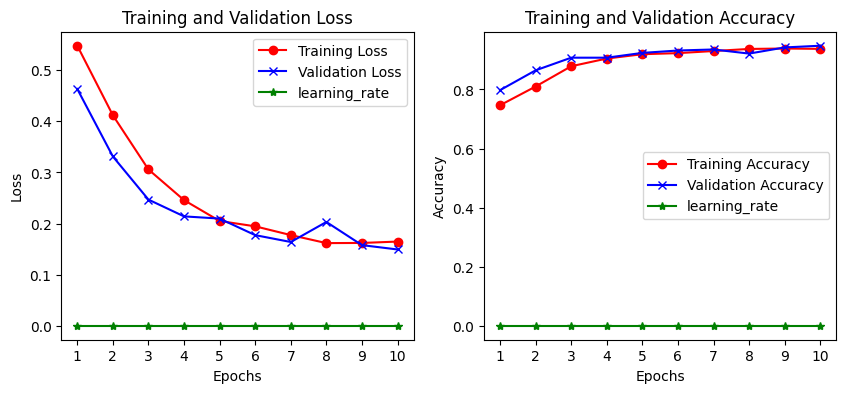

In [ ]:
plot_training_loss_accuracy_history(final_model_jitter_history)

In [ ]:
evaluate_model(final_model_jitter, test_ds_jitter)

54/54 [==============================] - 9s 161ms/step - loss: 0.1642 - accuracy: 0.9410
Test Loss: 0.16418446600437164
Test Accuracy: 0.9409722089767456


In [ ]:
calculate_metrics(final_model_jitter, test_ds_jitter)

Precision: 0.9638157894736842
Recall: 0.9559543230016313
F1-score: 0.9598689598689598


Confusion Matrix:
[[228  23]
 [ 28 585]]


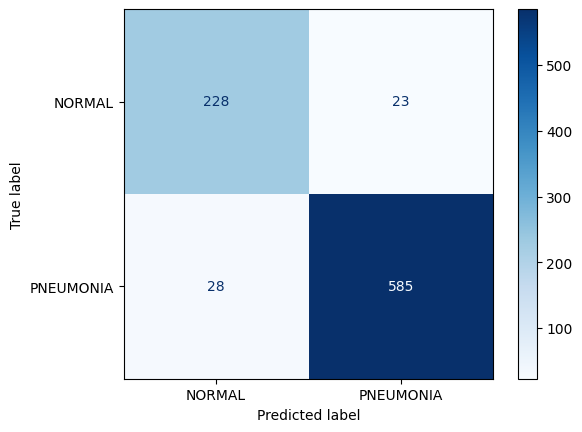

In [ ]:
plot_confusion_matrix(final_model_jitter, test_ds_jitter)

By observing this confusion matrix, we notice that this model performs better than SVM, RandomForest and AdaBoost classifiers with NORMAL images. It produces better results than DecisionTree and xgBoost classifiers both with NORMAL and PNEUMONIA images.

### Using Layers Augmentation

Here we do the same process as in the previous subsection but we train our model architecture with data preprocessed with layer augmentation.

In [38]:
train_ds_layers_augmentation = prepare_data(train_dataset, batch_size, shuffle=True, shuffle_buffer_size=1000, jitter=False, layers_augmentation=True)
val_ds_layers_augmentation = prepare_data(val_dataset, batch_size, shuffle=False, jitter=False, layers_augmentation=True)
test_ds_layers_augmentation = prepare_data(test_dataset, batch_size, shuffle=False, jitter=False, layers_augmentation=True)

In [39]:
input_shape = train_ds_layers_augmentation.take(1).__iter__().next()[0].shape[1:]
print(input_shape)

(224, 224, 3)


In [40]:
checkpoint_path = "training_layers_augmentation/cp"
checkpoint_dir = os.path.dirname(checkpoint_path)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)
]

In [41]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    seed=42,
    executions_per_trial=1,
    project_name='pneumonia_detection_layers_augmentation'
)
tuner.search(train_ds_layers_augmentation, epochs=6, validation_data=val_ds_layers_augmentation, callbacks=callbacks)

Trial 5 Complete [00h 03m 52s]
val_accuracy: 0.9282407164573669

Best val_accuracy So Far: 0.9282407164573669
Total elapsed time: 00h 21m 42s


In [42]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [43]:
final_model_layers_aug = tuner.hypermodel.build(best_hps)

In [44]:
final_model_layers_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 93312)            

In [ ]:
final_model_layers_aug_history = final_model_layers_aug.fit(train_ds_layers_augmentation, epochs=10, validation_data=val_ds_layers_augmentation, callbacks=callbacks)

Epoch 1/10
256/256 [==============================] - 30s 109ms/step - loss: 0.3822 - accuracy: 0.8411 - val_loss: 0.2503 - val_accuracy: 0.9097 - lr: 2.9415e-04
Epoch 2/10
256/256 [==============================] - 27s 106ms/step - loss: 0.2622 - accuracy: 0.8955 - val_loss: 0.1952 - val_accuracy: 0.9213 - lr: 2.9415e-04
Epoch 3/10
256/256 [==============================] - 23s 89ms/step - loss: 0.2471 - accuracy: 0.9048 - val_loss: 0.2084 - val_accuracy: 0.9109 - lr: 2.9415e-04
Epoch 4/10
256/256 [==============================] - 28s 108ms/step - loss: 0.2271 - accuracy: 0.9126 - val_loss: 0.2141 - val_accuracy: 0.9167 - lr: 2.9415e-04
Epoch 5/10
256/256 [==============================] - 24s 96ms/step - loss: 0.1874 - accuracy: 0.9285 - val_loss: 0.1512 - val_accuracy: 0.9444 - lr: 5.8830e-05
Epoch 6/10
256/256 [==============================] - 28s 111ms/step - loss: 0.1779 - accuracy: 0.9270 - val_loss: 0.1546 - val_accuracy: 0.9363 - lr: 5.8830e-05
Epoch 7/10
256/256 [==========

Considering the train accuracy, val accuracy and the losses we can see that the model performs better with data preprocessed with color jittering.

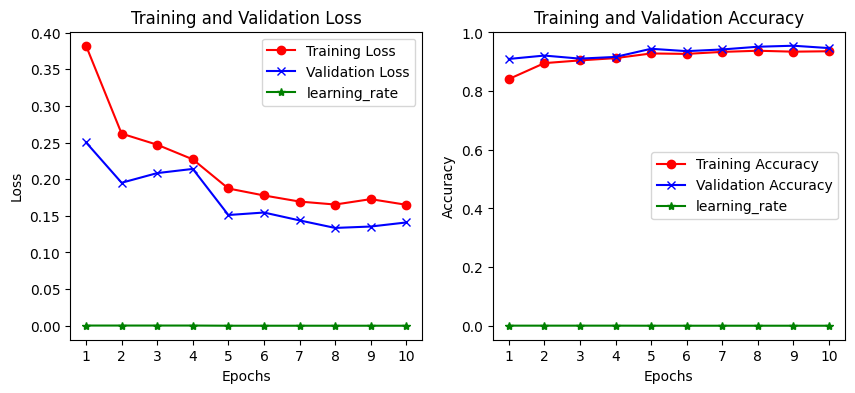

In [ ]:
plot_training_loss_accuracy_history(final_model_layers_aug_history)

In [ ]:
evaluate_model(final_model_layers_aug, test_ds_layers_augmentation)

54/54 [==============================] - 8s 150ms/step - loss: 0.1617 - accuracy: 0.9387
Test Loss: 0.16167165338993073
Test Accuracy: 0.9386574029922485


In [ ]:
calculate_metrics(final_model_layers_aug, test_ds_layers_augmentation)

Precision: 0.9639344262295082
Recall: 0.9592169657422512
F1-score: 0.9615699100572364


Confusion Matrix:
[[228  23]
 [ 25 588]]


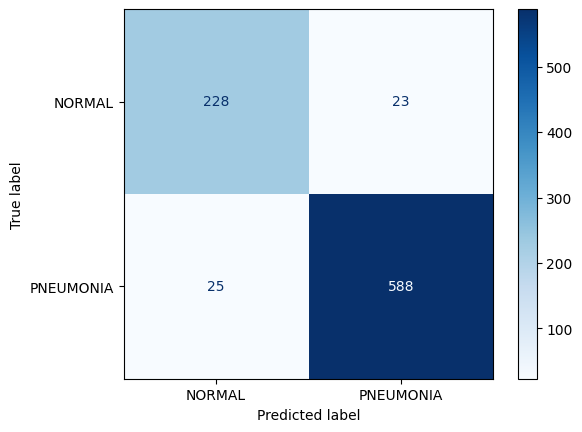

In [ ]:
plot_confusion_matrix(final_model_layers_aug, test_ds_layers_augmentation)

Instead on the test dataset the two model configurations perform similarly. We can observe that from the confusion matrix as well.

## Model Inference

In this subsection we run inference on both the deep learning models created: the one trained with data preprocessed with color jittering and the one trained with data preprocessed with layer augmentation. We make our models predict the labels of the test data, which they have never seen before. We take 10 random test images and we print their true labels and predicted labels. We can see that the models are able to correctly classify the images, accordingly to the metrics and confusion matrix shown above.

For our model inference we create the **binary_prediction** function that takes as input a model and the path to the train images and returns the predictions of the model together with the confidence. Confidence represent how sure the model is about the prediction.

For higher readability we created an Enumaration class that contains the three possible categories of confidence.

In [ ]:
class ConfidenceCategory(Enum):
  NOT_VERY_CONFIDENT = 'Not very confident'
  QUITE_CONFIDENT = 'Quite confident'
  VERY_CONFIDENT = 'Very confident'

Inside the function the confidence is categorized as follows:
- **NOT_VERY_CONFIDENT**: if 0.35 <= confidence <= 0.50 or 0.50 < confidence <= 0.65.
- **QUITE_CONFIDENT**: if 0.20 <= confidence < 0.35 or 0.65 < confidence <= 0.80.
- **VERY_CONFIDENT**: if 0.00 <= confidence < 0.20 or 0.80 < confidence <= 1.00.


In [ ]:
def binary_prediction(model, image_path, threshold=0.5):
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=(input_shape[0], input_shape[1]))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  predictions = model.predict(img_array)

  confidence = predictions[0]
  if 0.35 <= confidence <= 0.50 or 0.50 < confidence <= 0.65:
    confidence_category = ConfidenceCategory.NOT_VERY_CONFIDENT.value
  elif 0.20 <= confidence < 0.35 or 0.65 < confidence <= 0.80:
    confidence_category = ConfidenceCategory.QUITE_CONFIDENT.value
  else:
    confidence_category = ConfidenceCategory.VERY_CONFIDENT.value

  predicted_class = 'PRENUMONIA' if predictions[0] > threshold else 'NORMAL'

  return predicted_class, confidence_category


PNEUMONIA
1/1 [==============================] - 0s 18ms/step


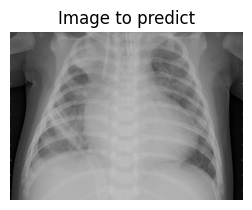

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 18ms/step


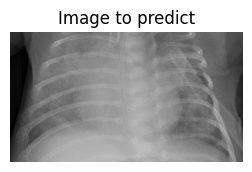

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 19ms/step


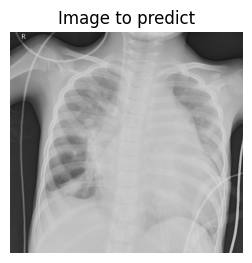

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 17ms/step


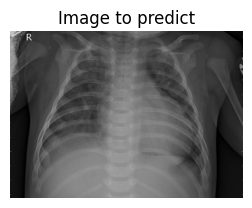

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 18ms/step


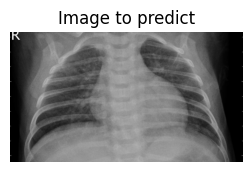

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
NORMAL
1/1 [==============================] - 0s 18ms/step


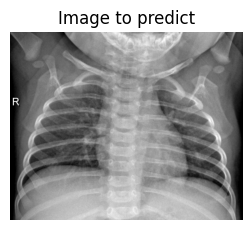

Predicted Class: NORMAL
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 18ms/step


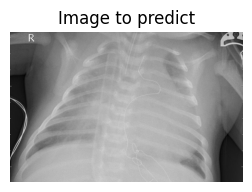

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
NORMAL
1/1 [==============================] - 0s 20ms/step


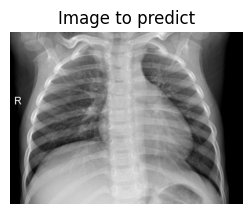

Predicted Class: NORMAL
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 18ms/step


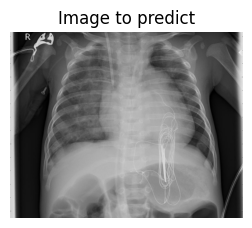

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 18ms/step


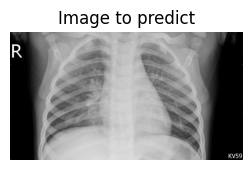

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------


In [ ]:
random_indixes = np.random.choice(len(test_df)-1, 10, replace=False)

for index in random_indixes:
  image_path = os.path.join('chest_xray', test_df.iloc[index]['label'], test_df.iloc[index]['image'])
  image_to_predict_path = image_path
  print(test_df.iloc[index]['label'])
  predicted_class, confidence_category = binary_prediction(final_model_jitter, image_to_predict_path)

  img = cv2.imread(image_path)
  plt.figure(figsize=(3,3))
  plt.imshow(img)
  plt.title('Image to predict')
  plt.axis('off')
  plt.show()

  print(f'Predicted Class: {predicted_class}')
  print(f'Confidence: {confidence_category}')
  print('------------------------------------------------------')

PNEUMONIA
1/1 [==============================] - 0s 390ms/step


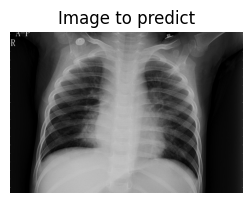

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 18ms/step


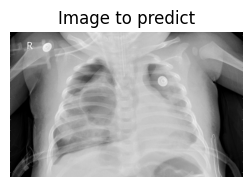

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 19ms/step


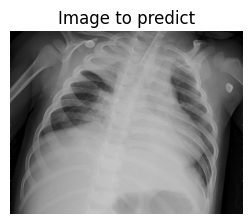

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
NORMAL
1/1 [==============================] - 0s 18ms/step


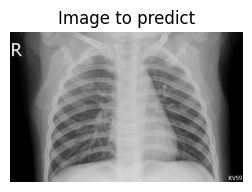

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 20ms/step


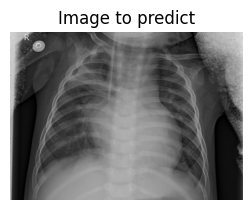

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 19ms/step


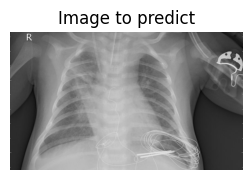

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
NORMAL
1/1 [==============================] - 0s 19ms/step


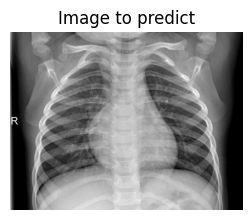

Predicted Class: NORMAL
Confidence: Very confident
------------------------------------------------------
NORMAL
1/1 [==============================] - 0s 18ms/step


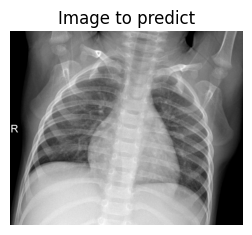

Predicted Class: NORMAL
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 19ms/step


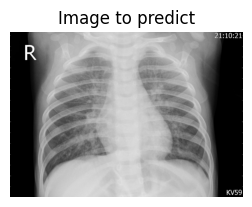

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------
PNEUMONIA
1/1 [==============================] - 0s 19ms/step


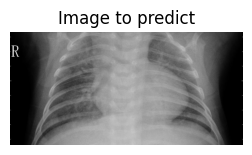

Predicted Class: PRENUMONIA
Confidence: Very confident
------------------------------------------------------


In [ ]:
random_indixes = np.random.choice(len(test_df)-1, 10, replace=False)

for index in random_indixes:
  image_path = os.path.join('chest_xray', test_df.iloc[index]['label'], test_df.iloc[index]['image'])
  image_to_predict_path = image_path
  print(test_df.iloc[index]['label'])
  predicted_class, confidence_category = binary_prediction(final_model_layers_aug, image_to_predict_path)

  img = cv2.imread(image_path)
  plt.figure(figsize=(3,3))
  plt.imshow(img)
  plt.title('Image to predict')
  plt.axis('off')
  plt.show()

  print(f'Predicted Class: {predicted_class}')
  print(f'Confidence: {confidence_category}')
  print('------------------------------------------------------')